In [2]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

In [3]:
# Model parameters
params = {
    'N' : 2000,
    'k' : 50,
    'a' : 0.3,
    'r' : 1

}

In [4]:
m=params['k']
nx=params['N']
a=params['a']

eigm = (np.linspace(0,m-1,m)+1/2)*np.pi
eig_m      = eigm.reshape(-1,1)
# Fix the base definition
#v1         = ((2*np.linspace(0,self.nx-1,self.nx)+1)*h/2).reshape(1,-1)
v1         = ((2*np.linspace(0,nx-1,nx)+1)/(2*nx)).reshape(1,-1)
# we consider base[i](nx) = 0, then v1[nx] = 1. And v1[0] = 0.
v1         = ((2*np.linspace(0,nx-1,nx))/(2*nx)).reshape(1,-1)
v2         = (np.ones(nx)/(2*nx)).reshape(1,-1)

#### OBSERVATION: The base differs from the theory on the paper!!!

In [5]:
base       = 2*np.sqrt(2)/eig_m*np.cos(v1*eig_m)*np.sin(v2*eig_m)

### Is the base orthogonal?

In [6]:
def inner_prod(f1,f2):
    N = len(f1)
    h = 1/N
    kernel = 2*np.ones(N)
    kernel[0] = 1
    A=np.diag(kernel)
    return f1.T.dot(A).dot(f2)*h/2

In [7]:
def normalize_base(base):
    for i, f in enumerate(base):
        base[i] = f/np.sqrt(inner_prod(f,f))
    return base

In [8]:
base = normalize_base(base)

In [9]:
phisics = Physics(params['N'],params['k'],params['a'],params['r'])

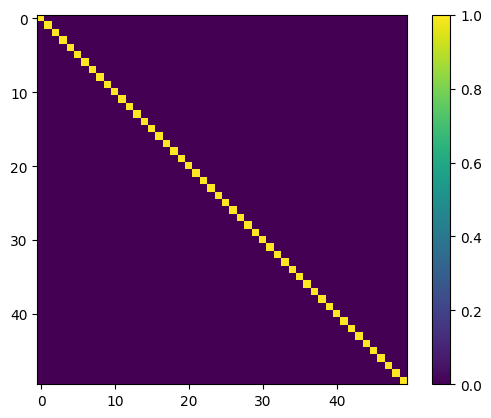

In [10]:
cross_prod =  np.zeros((params['k'],params['k']))

for i in range(params['k']):
    for j in range(params['k']):
        cross_prod[i,j] = phisics.inner_prod(phisics.basis[i], phisics.basis[j])

plt.imshow(cross_prod)
plt.colorbar()
plt.show()

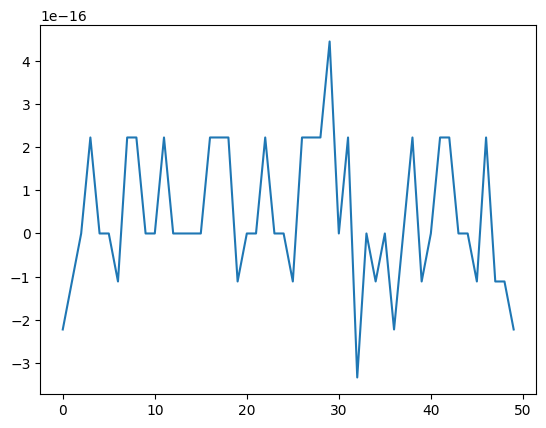

In [11]:
plt.plot(np.diag(cross_prod)-1)
plt.show()

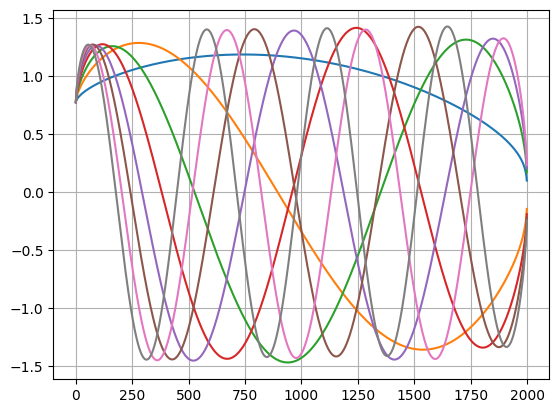

In [12]:
for i in range(8): 
    plt.plot(phisics.basis[i])
plt.grid(True,'both')

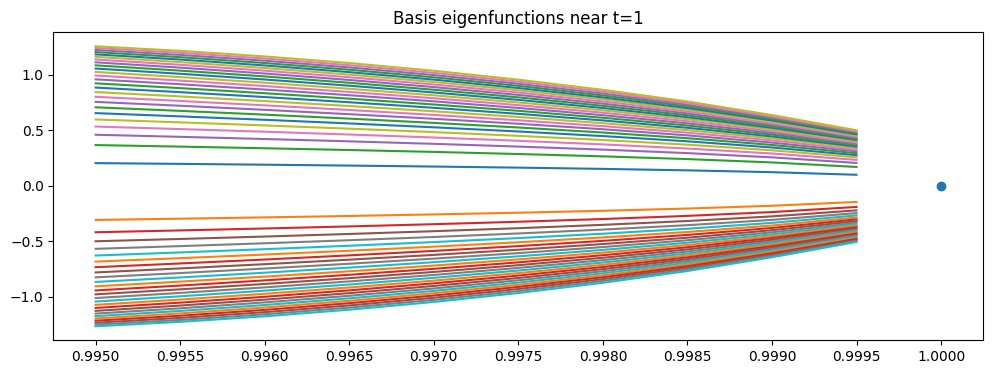

In [13]:
t = np.linspace(0,(params['N']-1)/params['N'],params['N'])
plt.figure(figsize=(12,4))
for func in phisics.basis:
    plt.plot(t[params['N']-10:], func[params['N']-10:])

plt.plot(1,0, marker='o')
plt.xticks(t[params['N']-11:]+t[1])
plt.title('Basis eigenfunctions near t=1')
plt.show()

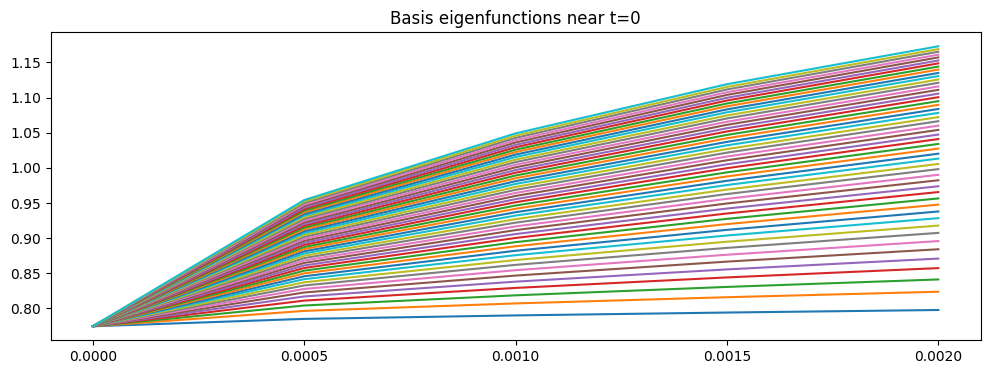

In [14]:
plt.figure(figsize=(12,4))
for func in phisics.basis:
    plt.plot(t[:5], func[:5])

#plt.plot(1,0, marker='o')
plt.xticks(t[:5])
plt.title('Basis eigenfunctions near t=0')
plt.show()

In [15]:
def project(x, base):
    N = len(x)
    h = 1/N
    kernel = 2*np.ones(N)
    kernel[0] = 1
    A=np.diag(kernel)
    return h/2*base.dot(A).dot(x)

<BarContainer object of 50 artists>

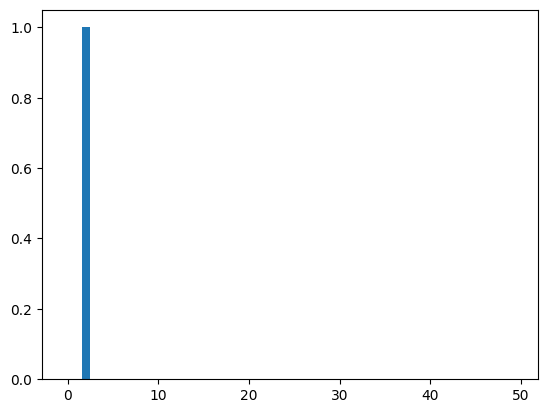

In [16]:
plt.bar(range(50),project(base[2], base))

# Create Model

In [17]:
model = FBRestNet(
    model_id = 'model_000_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(params['N'],params['k'],params['a'],params['r']),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=64,
    lr=3e-1, 
    nb_epochs=50,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=False,
    save_model=False,
    save_hist=True
    )

In [18]:
# Generate dataset
train_set, val_set = model.CreateDataSet()

In [19]:
# Select one signal
signal_id = 1
[y,x] = val_set.dataset[signal_id:signal_id+1]
x_true = Variable(x, requires_grad=False)
x_bias = Variable(y, requires_grad=False)

# Test eigensystem

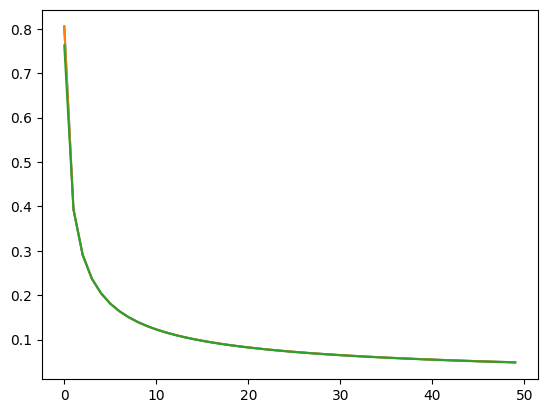

In [29]:
plt.plot(model.physics.eigw)
plt.plot(model.physics.eigm**(-2*a))
plt.plot(((np.linspace(0,m-1,m)+1/2)*np.pi)**(-2*a))
plt.show()

[]

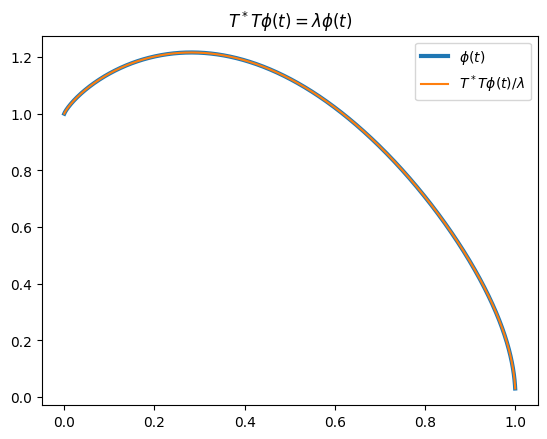

In [21]:
idx = 0

Tadj = model.physics.Tadj.copy()
Ta = model.physics.Ta.copy()

eig_func = model.physics.basis[idx,:]
eig_val  = (1/model.physics.eigm**(2*a))[idx]
plt.plot(t,eig_func, label=r'$\phi(t)$', linewidth=3)
plt.plot(t,Tadj.dot(Ta).dot(eig_func) / eig_val, label=r'$T^*T\phi(t) / \lambda$')
plt.title(r'$T^*T\phi(t)=\lambda \phi(t)$')
plt.legend()
plt.plot()

In [22]:
print('phi(t)')
print('min: {}\nmax: {}'.format(max(eig_func), min(eig_func)))
print('T*Tphi(t)/lambda')
print('min: {}\nmax: {}'.format(max(Tadj.dot(Ta).dot(eig_func) / eig_val), min(Tadj.dot(Ta).dot(eig_func) / eig_val)))

phi(t)
min: 1.2158909502513913
max: 0.03057218489842439
T*Tphi(t)/lambda
min: 1.2158909502513908
max: 0.03057218489842437


# Test the basis change

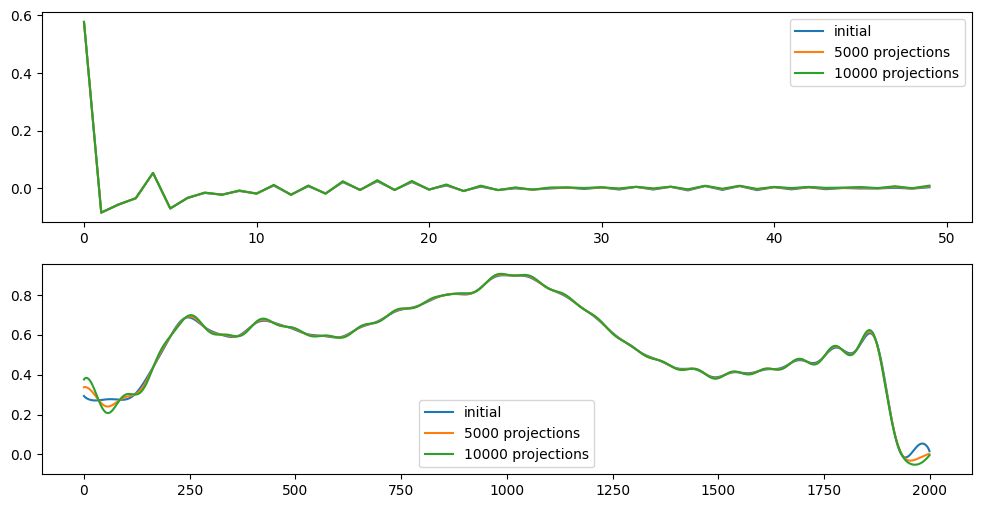

In [23]:
fig, ax = plt.subplots(2,1,figsize=(12,6))

ax[0].plot(x_true.numpy()[0,0], label='initial')
x_true_elt = np.matmul(x_true,model.physics.basis).numpy()[0,0]
ax[1].plot(x_true_elt, label='initial')

n_proj = 10000

for i in range(n_proj):
    x_true_hat = model.physics.BasisChange(x_true_elt)
    x_true_elt = model.physics.BasisChangeInv(x_true_hat)
    if i == n_proj/2:
        ax[0].plot(x_true_hat, label='{} projections'.format(i))
        ax[1].plot(x_true_elt, label='{} projections'.format(i))

ax[0].plot(x_true_hat, label='{} projections'.format(n_proj))
ax[1].plot(x_true_elt, label='{} projections'.format(n_proj))
ax[0].legend()
ax[1].legend()
plt.show()
